In [49]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService , SamplerV2
import numpy as np
from qiskit.quantum_info import Operator
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import math
import scipy as sp
from qiskit.visualization import array_to_latex
from qiskit_aer import StatevectorSimulator, AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_ibm_runtime.fake_provider import FakeKyiv

In [50]:
n = 2#Number of Qubits

In [51]:
#Load b
b = np.array([0,1])  
b_norm = b / np.linalg.norm(b)
initialn= int(np.log2(len(b_norm)))
initialstate = QuantumCircuit(initialn)
initialstate.initialize(b_norm, range(initialn))

In [52]:
#Define A
A = np.array([[1, -1/3],
             [-1/3, 1]]) 

#Define U
t  = 3 * np.pi / 4
U_matrix = sp.linalg.expm(1j*A*t)
U = Operator(U_matrix)
U_gate = U.to_instruction()
xsol=sp.linalg.solve(A,b)
display(array_to_latex(xsol,prefix="x_{sol}="))
xsol = float(xsol[1])**2/float(xsol[0])**2
print(xsol)

<IPython.core.display.Latex object>

9.0


In [53]:
#Quantum Fourier Transform
q = initialn+n-1
qft = QuantumCircuit(q)
iqft = QuantumCircuit(q)
for j in range(q//2):
    qft.swap(j, q-j-1)
for i in range(q):
    qft.h(i)
    for k in range(i+1,q):
        qft.cp(np.pi/(2**(k-i)), k,i)

iqft = iqft.compose(qft.inverse())
IQFT = iqft.to_gate(label="IQFT")

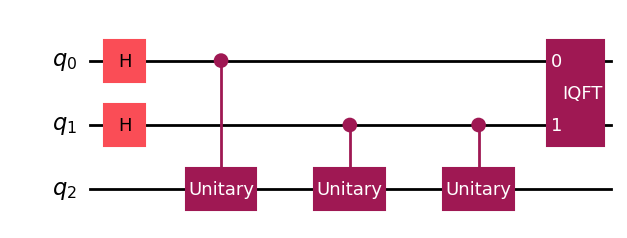

In [54]:
#Quantum Phase Estimation
qpe = QuantumCircuit(n+initialn)
iqpe = QuantumCircuit(n+initialn)

for i in range(initialn+n-1):
    qpe.h(i)
for k in range(initialn+n-1):
    for z in range(2**k):
        controlled_U = U_gate.control(1)
        qpe.append(controlled_U, [k, n])
        
qpe.append(IQFT, range(q))
QPE = qpe.to_gate(label="QPE")
iqpe = iqpe.compose(qpe.inverse())
IQPE = iqpe.to_gate(label="IQPE")
qpe.draw("mpl")

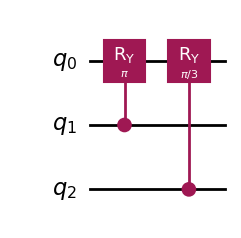

In [55]:
#Controlled Rotation
C = 1
crot = QuantumCircuit(n+1)
for i in range(n):  
    crot.cry(2 * math.asin(C / (i+1)), i+1, 0)
CROT = crot.to_gate(label="CROT")
crot.draw("mpl")

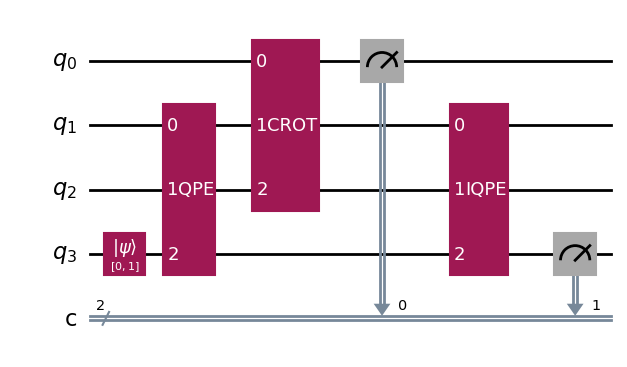

In [60]:

# Harrow–Hassidim–Lloyd Algorithm
HHL = QuantumCircuit(n+initialn+1,2)
HHL = HHL.compose(initialstate, range(n+1,n+1+initialn,1))
HHL = HHL.compose(QPE, range(1,initialn+1+n,1))
HHL = HHL.compose(CROT, range(n+1))
HHL.measure(0,0)
HHL = HHL.compose(IQPE, range(1,initialn+1+n,1))
HHL.measure(n+initialn,1)
HHL.draw("mpl")

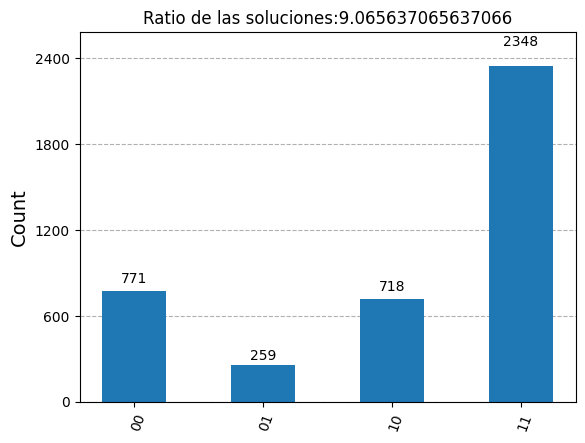

In [38]:
#SIMULACION IDEAL. NO NOISE

backend = GenericBackendV2(n+initialn+1)
transpiled_circuit = transpile(HHL, backend) 
job = backend.run(transpiled_circuit, shots = 4096, noise_model=None)
counts = job.result().get_counts()
plot_histogram(counts, title = "Ratio de las soluciones:"+str(int(counts["11"])/int(counts["01"]))) #orden registros clasicos derecha el 0

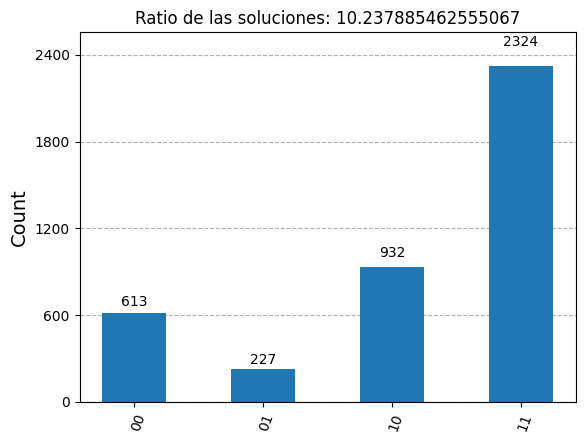

In [32]:
#SIMULACION REAL. WITH MODELED NOISE

noise_model = NoiseModel()

#1-qubit gate noise
error = depolarizing_error(0, 1)  #1-qubit gate error. 1% chance of being replaced by a completely random qubit (uniform over the Bloch sphere).
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3', 'rz', 'sx', 'x'])

#2-qubit gate noise
cx_error = depolarizing_error(0, 2) #Control X error. 
noise_model.add_all_qubit_quantum_error(cx_error, ['cx'])

noisy_backend = AerSimulator(noise_model=noise_model)
transpiled_circuit = transpile(HHL, noisy_backend)
job = noisy_backend.run(transpiled_circuit, shots=4096)
counts = job.result().get_counts()
plot_histogram(counts, title="Ratio de las soluciones: " + str(int(counts.get("11", 0)) / int(counts.get("01", 1))))

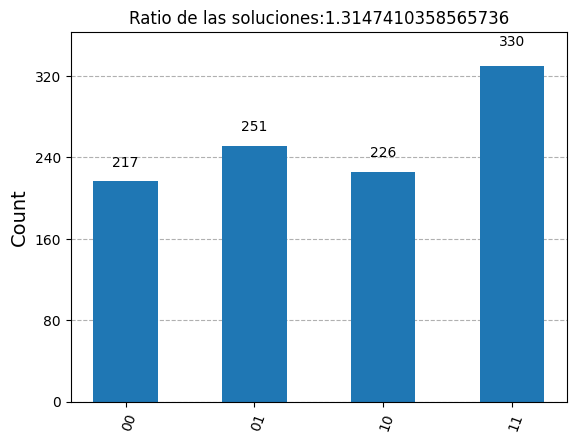

In [11]:
#SIMULACION REAL. NOISE SIMULATED. FAKE PROVIDER

backend = FakeKyiv()
initial_layout = [15,22,21,23] #Keys are virtual qubits, and values are physical qubits.

transpiled_circuit = transpile(HHL, backend, initial_layout = initial_layout) 
job = backend.run(transpiled_circuit, shots = 1024, optimization_level=3)
counts = job.result().get_counts()
plot_histogram(counts, title = "Ratio de las soluciones:"+str(int(counts["11"])/int(counts["01"]))) #orden registros clasicos derecha el 0

In [28]:
#SIMULACION REAL.

token = "001157e610e373c81cd9f59d74a91d346c12941a99675f9eef2336c57f483904b135842e974dd4856a62d6faf731fe59afbef1b70d929fd880cc72155af07d56"

QiskitRuntimeService.save_account(channel = 'ibm_quantum', instance = 'ibm-q/open/main', token = token, overwrite = True)
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
print(backend)
 
# Convert to an ISA circuit. OPTIMIZATION!
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, initial_layout = initial_layout)
isaHHL = pm.run(HHL)
 
#isaHHL.draw("mpl", idle_wires=False)

sampler=SamplerV2(mode=backend)
job = sampler.run([isaHHL],shots=1024)
print(job.job_id())

<IBMBackend('ibm_kyiv')>
cztezd5nhqag008sye0g


In [31]:
job.status()

'DONE'

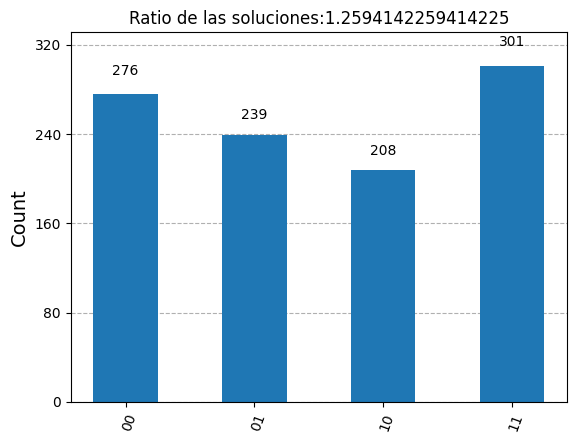

In [32]:
countsreal = job.result()[0].data.c.get_counts() 
plot_histogram(countsreal, title = "Ratio de las soluciones:"+str(int(countsreal["11"])/int(countsreal["01"]))) #orden registros clasicos derecha el 0